3DDiff file using smoother step profiles of Kv
================================================================

### Smoothed $\kappa$ profile

What happens if we smooth out the diffusivity profile from a step (Heaviside function) to a smoothed Heaviside function? (The concentration will look smoother but how does it change the tracer transport?)

Smoothed Heaviside function:

$HS(z) = \begin{cases}
\kappa_{bg} &\mbox{if } z<\frac{L}{2}-\epsilon \\
\kappa_{bg}+ \kappa_{can}(0.5 + \frac{z-\epsilon}{2\epsilon} + \frac{1}{2\pi}\sin{\frac{\pi(z-\epsilon)}{\epsilon}}) & \mbox{if } \frac{L}{2}-\epsilon < z < \frac{L}{2}+\epsilon \\
\kappa_{can} & \mbox{if }  \frac{L}{2}+\epsilon < z
 \end{cases} $

We will compare several values of $\epsilon$.


In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.interpolate as interp
import seaborn as sns
import struct

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
import canyon_tools.readout_tools as rout

### Functions

In [18]:
def smoothHS(nx, xi, epsilon, dx, k1, k2, Z):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx.
    In this case, epsilon = smoothness/dx, where smoothness 
    is the 1/2 distance over which the transition from kbg to kcan happens.''' 
    
    hs = np.zeros(nx)
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                            (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2

    hs[xi+epsilon-1:] = k2+k1
    return hs
# ------------------------------------------------------------------------------
def smoothHS_res(nrim, epsilon, dz, k1, k2, Z):

    width = 0
    i_top = nrim
    # Find number of depth levels above rim to make thickness epsilon
    while width < epsilon:
        width = width + dz_vec[i_top]
        i_top = i_top - 1
    
    i_bot = nrim    
    width = 0
    # Find number of depth levels above rim to make thickness epsilon
    while width < epsilon-(dz_vec[i_bot]/2):
        width = width + dz_vec[i_bot]
        i_bot = i_bot + 1
   
    hs = np.zeros(np.shape(RC))
    hs[:i_top+1] = k1
      
    for ii in range(i_top,i_bot):
    
        zz = -(Z[ii]-Z[i_top]) # depth is negative
        hs[ii] = k1 + (0.5 + (zz-epsilon)/(2*epsilon) + (np.sin(np.pi*(zz-epsilon)/epsilon))/(2*np.pi))*k2
        
    hs[i_bot-1:] = k2+k1
    
    return(hs)  
#------------------------------------------------------------------------------------------------------------------------
def smooth_3D_diff(kv_array, W=13000, kbg = 1e-5, smooth=True):
    '''Exponential smoothing of a 3D kv map
    kv_smooth: np array with 3D map of diffusivities
    W: Exponential length scale of decay will be 0.25*W
    kbg: background diffusivity.
    
    This function is slooooooow'''
    
    kv_smooth = np.copy(kv_array)
    # Break canyon into 2 sections vertically and horizontally
    xini_h1 = 0
    xfin_h1 = 180
    xini_h2 = 180
    xfin_h2 = 615
    yini_h1 = 0
    yfin_h1 = 75
    yini_h2 = 267
    yfin_h2 = 359

    if smooth == True:
        # Apply exponential smoothing to each half
        for kk in range(90):

            for jj in range(360):
                for ii in range(xini_h2, xfin_h2, 1):
                    if np.isnan(kv_array[kk,jj,ii+1]) == True:
                        lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                        k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(X[ii:]-X[ii]))
                        kv_smooth[kk,jj,ii:] = k_sm
                        break

                for ii in range(xfin_h1, xini_h1, -1):
                    if np.isnan(kv_array[kk,jj,ii-1]) == True:
                        lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                        k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(-X[:ii]+X[ii]))
                        kv_smooth[kk,jj,:ii] = k_sm
                        break

            for ii in range(616):
                for jj in range(yini_h2, yfin_h2, 1):
                    if np.isnan(kv_array[kk,jj+1,ii]) == True:
                        lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                        k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(Y[jj:]-Y[jj]))
                        kv_smooth[kk,jj:,ii] = k_sm
                        break

                for jj in range(yfin_h1, yini_h1, -1):
                    if np.isnan(kv_array[kk,jj-1,ii]) == True:
                        lam = -(1/(0.25*W))*np.log(kbg/kv_array[kk,jj,ii]) 
                        k_sm = kv_array[kk,jj,ii]*np.exp(-lam*(-Y[:jj]+Y[jj]))
                        kv_smooth[kk,:jj,ii] = k_sm
                        break
    else:
        print('No smoothing')

    kv_final = np.where(np.isnan(kv_smooth)== True , kbg, kv_smooth)
    kv_final = np.where(kv_final < kbg , kbg, kv_final)
    return kv_final

#------------------------------------------------------------------------------------------------------------------------
def build_3D_diff_rim(hFacC, kv_bg, kv_can, delta, thresh, RC, dz, epsilon):
    
    kv_array = np.ones(np.shape(hFacC))*np.nan # Initial kv array
    ind_canyon = np.argwhere(delta > thresh) # horizontal indices of canyon, (y,x)
    
    ii = 0

    for ind in ind_canyon:
        rim_ind = np.argmin(hFacC[:,ind[0],ind[1]]) # find bottom z-index (first zero in hFacC no canyon)

        if rim_ind == 0: # this means hfac=1 through the whole water col
            rim_ind = 89

        dz_rim = dz[rim_ind]
        
        step = max([int(epsilon),dz_rim]) # This step is important to make e=5 cases = to original enhanced diff.
        
        kappa_profile = smoothHS_res(rim_ind, epsilon, dz, kv_bg, kv_can, RC)
        kv_array[:, ind[0], ind[1]] = kappa_profile
        ii = ii+1

    return kv_array

#------------------------------------------------------------------------------------------------------------------------
def final_3D_diff(hFacCnoc, kv_bg, kv_can, delta, thresh, RC, dz, epsilon, W=13000, kbg = 1e-5, smoothing = False):
    '''make final, 3D map of diffusivities based on kv_profile. If smoothing=True then the final profile
    will be smoothed using smooth_3D_diff. '''
    
    kv_temp = build_3D_diff_rim(hFacCnoc, kv_bg,kv_can, delta, thresh, RC, dz, epsilon)
    kv_map = smooth_3D_diff(kv_temp, W, kbg, smooth=smoothing)
    
    return kv_map


In [5]:
def plot_sections(kv_map, canyon_name):

    masked_logkvsm = np.ma.masked_array(np.log10(kv_map), mask = land_mask)

    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,10.5))

    mesh = ax1.pcolor(Y[:]/1000,RC[:], masked_logkvsm[:,:,180] , vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax1)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax1.set_title('Cross-section along canyon axis, %s' %canyon_name)
    ax1.set_ylabel('m')
    ax1.set_xlabel('km')
    ax1.plot(Y[:]/1000, -depth_Can[:,280], 'k-')

    mesh = ax2.pcolor(X[:]/1000,RC[:], masked_logkvsm[:,227,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax2)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax2.set_title('Cross-section along mid-length')
    ax2.set_ylabel('m')
    ax2.set_xlabel('km')
    ax2.set_ylim(-600,0)
    ax2.set_xlim(45,75)

    mesh = ax3.pcolor(X[:]/1000,Y[:]/1000, masked_logkvsm[29,:,:], vmax=-1, vmin=-6, cmap = cmo.cm.delta)
    cb = plt.colorbar(mesh, ax=ax3)
    cb.set_label(r'log$_{10}$($K_v$ / m$^2$s$^{-1}$)')
    ax3.set_title('Top view at depth %1.1f m' % RC[29])
    ax3.set_ylabel('km')
    ax3.set_xlabel('km')
    ax3.set_aspect(1)

    plt.tight_layout()
    
    return(fig, ax1, ax2, ax3)

### Input

In [6]:
## Get grid variables

fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
GridOutNoC = Dataset(fileNoC)

fileCan='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
GridOut = Dataset(fileCan)

depth_NoC = rout.getField(fileNoC,'Depth')
depth_Can = rout.getField(fileCan,'Depth')

hFacC = rout.getField(fileNoC,'HFacC') #(90,616,360)
hFacCcan = rout.getField(fileCan,'HFacC') #(90,616,360)
land_mask = rout.getMask(fileCan, 'HFacC') 

Y = GridOut.variables['Y']
X = GridOut.variables['X']
RC = GridOut.variables['RC']

dz_vec = GridOut.variables['drC'][:]

### Heaviside profiles of diffusivity

These will be the profiles I'll use as smooth steps. I need to interpolate them to the rim depth as I did for the "realistic profiles", stretching and squeezing them as needed along and across the canyon.

In [7]:
#Input 
nx = 616
ny = 360
nz = 90
dz = 5 # m at rim

# Space
L = 1200            # total depth (m)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-2-(1E-5)

In [13]:
# Examples of profiles using different smoothing length scale epsilon. 
# Min epsilon I can use is 5 m = dz but that just looks like a step

e5 = 5 # 5m/dz
kappa_e5 = smoothHS_res(26, e5, dz_vec, kappa_bg, kappa_can, RC) 
# index 26 corresponds to the rim at station DnS, but the rim location changes from place to place in the canyon

e15 = 15 # 15m/dz
kappa_e15 = smoothHS_res(26, e15, dz_vec, kappa_bg, kappa_can, RC) 

e50 = 50 # 50m/dz
kappa_e50 = smoothHS_res(26, e50, dz_vec, kappa_bg, kappa_can, RC) 

e100 = 100 # 100m/dz
kappa_e100 = smoothHS_res(26, e100, dz_vec, kappa_bg, kappa_can, RC) 

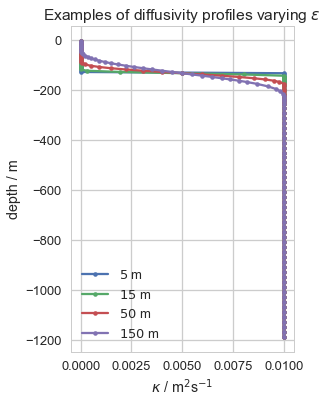

In [14]:
# Plot kv profiles
sns.set_context('talk')
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(4,6))

ax.plot(kappa_e5,RC,'.-', label = '$5$ m')
ax.plot(kappa_e15,RC,'.-', label = '$15$ m')
ax.plot(kappa_e50,RC,'.-', label = '$50$ m')
ax.plot(kappa_e100,RC,'.-', label = '$150$ m')


ax.set_xlabel('$\kappa$ / m$^2$s$^{-1}$')
ax.set_ylabel('depth / m')
ax.set_title('Examples of diffusivity profiles varying $\epsilon$')

#ax.set_ylim(-250,0)
ax.legend(loc=0)

### Find canyon indices

In [15]:
# Isolate canyon
thresh = 0.1 # min vertical resolution
delta = depth_Can-depth_NoC
delta_masked = np.ma.masked_less_equal(delta, thresh)
    
print(np.shape(delta))

(360, 616)


Text(0,0.5,'km')

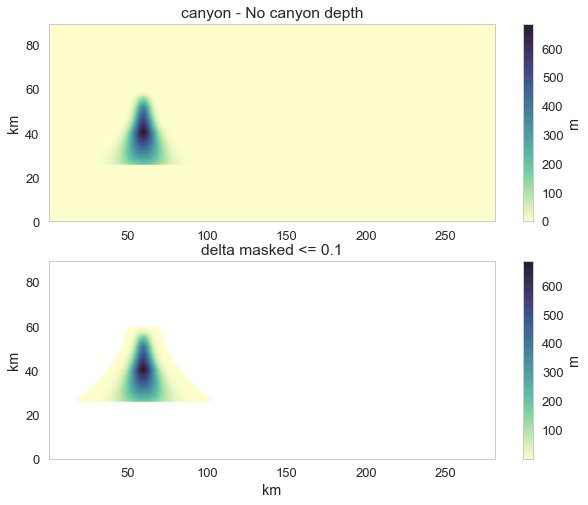

In [16]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
mesh = ax1.pcolor(X[:]/1000,Y[:]/1000, delta, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax1)
cb.set_label('m')
ax1.set_title('canyon - No canyon depth')
ax1.set_ylabel('km')

mesh = ax2.pcolor(X[:]/1000,Y[:]/1000, delta_masked, cmap = cmo.cm.deep)
cb = plt.colorbar(mesh, ax=ax2)
cb.set_label('m')
ax2.set_title('delta masked <= %1.1f' %thresh)
ax2.set_xlabel('km')
ax2.set_ylabel('km')

### Make 3D maps of kv based on heaviside profiles

Decay lengthscale to K_{bg} is  3250.0 m


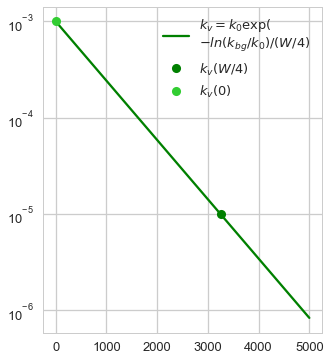

In [17]:
# Find an exponential to smooth out sharp interface. This will only be used if smoothing=True (not recomended) 
ko = 1E-3
kbg = 1E-5
W = 13000 # m
lam = -(1/(0.25*W))*np.log(kbg/ko) # decay scale so that at 1/4 of the canyon width the diffusivity is kbg
print('Decay lengthscale to K_{bg} is % 1.1f m' %(0.25*W))

# def exponential
x_vec = np.linspace(0,5000,50)
ksm = ko*np.exp(-lam*x_vec)

# plot
fig, (ax1) = plt.subplots(1,1, figsize=(5,6))
ax1.semilogy(x_vec,ksm, 'g-',label='$k_v=k_0 \exp({$\n$-ln(k_{bg}/k_{0})/(W/4)})$')
ax1.plot(0.25*W, kbg, 'go',label='$k_v(W/4)$' )
ax1.plot(0, ko, 'o',color='limegreen', label='$k_v(0)$')
ax1.legend(loc=0)
plt.show()

#### Now, make kv arrays to save later

In [19]:
# Kv = 1.2E-2 exact, change epsilon

kappa_can = 1.2E-2-(1E-5) # the minus 1E-5 is added because the heaviside function will add kbg+kcan as final kv within the canyon

kv_final_e05_1p2E2 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

No smoothing
done with epsilon 05, kappa_can 1.2e-02


In [20]:
# The exponential smoothing function is super slow - when smoothing = True, default is False 

# Kv = 1E-2 exact, change epsilon

kappa_can = 1E-2-(1E-5)

kv_final_e05 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

kv_final_e10 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 10, W=13000, kbg = 1e-5)
print('done with epsilon 10, kappa_can %1.1e' %kappa_can)

kv_final_e15 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 15, W=13000, kbg = 1e-5)
print('done with epsilon 15, kappa_can %1.1e' %kappa_can)

kv_final_e25 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 25, W=13000, kbg = 1e-5)
print('done with epsilon 25, kappa_can %1.1e' %kappa_can)

kv_final_e50 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 50, W=13000, kbg = 1e-5)
print('done with epsilon 50, kappa_can %1.1e' %kappa_can)

kv_final_e75 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 75, W=13000, kbg = 1e-5)
print('done with epsilon 75, kappa_can %1.1e' %kappa_can)

kv_final_e100 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 100, W=13000, kbg = 1e-5)
print('done with epsilon 100, kappa_can %1.1e' %kappa_can)


No smoothing
done with epsilon 05, kappa_can 1.0e-02
No smoothing
done with epsilon 10, kappa_can 1.0e-02
No smoothing
done with epsilon 15, kappa_can 1.0e-02
No smoothing
done with epsilon 25, kappa_can 1.0e-02
No smoothing
done with epsilon 50, kappa_can 1.0e-02
No smoothing
done with epsilon 75, kappa_can 1.0e-02
No smoothing
done with epsilon 100, kappa_can 1.0e-02


IndexError: index 91 is out of bounds for axis 0 with size 91

In [21]:
# Kv = 8E-3 exact, change epsilon

kappa_can = 8E-3-(1E-5)

kv_final_e05_kv8E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

No smoothing
done with epsilon 05, kappa_can 8.0e-03


In [22]:
# Kv = 5E-3 exact, change epsilon

kappa_can = 5E-3-(1E-5)

kv_final_e05_kv5E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

kv_final_e25_kv5E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 25, W=13000, kbg = 1e-5)
print('done with epsilon 25, kappa_can %1.1e' %kappa_can)

kv_final_e100_kv5E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 100, W=13000, kbg = 1e-5)
print('done with epsilon 100, kappa_can %1.1e' %kappa_can)

No smoothing
done with epsilon 05, kappa_can 5.0e-03
No smoothing
done with epsilon 25, kappa_can 5.0e-03
No smoothing
done with epsilon 100, kappa_can 5.0e-03


In [23]:
# Kv = 2.5E-3 exact, change epsilon

kappa_can = 2.5E-3-(1E-5)

kv_final_e05_kv2p5E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

No smoothing
done with epsilon 05, kappa_can 2.5e-03


In [24]:
# Kv = 1E-3 exact, change epsilon

kappa_can = 1E-3-(1E-5)

kv_final_e05_kv1E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

kv_final_e25_kv1E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 25, W=13000, kbg = 1e-5)
print('done with epsilon 25, kappa_can %1.1e' %kappa_can)

kv_final_e100_kv1E3 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 100, W=13000, kbg = 1e-5)
print('done with epsilon 100, kappa_can %1.1e' %kappa_can)

No smoothing
done with epsilon 05, kappa_can 9.9e-04
No smoothing
done with epsilon 25, kappa_can 9.9e-04
No smoothing
done with epsilon 100, kappa_can 9.9e-04


In [24]:
# Kv = 5E-4 exact, change epsilon

kappa_can = 5E-4-(1E-5)

kv_final_e05_kv5E4 = final_3D_diff(hFacC, kappa_bg, kappa_can, delta, thresh, RC, dz_vec, 5, W=13000, kbg = 1e-5)
print('done with epsilon 05, kappa_can %1.1e' %kappa_can)

No smoothing
done with epsilon 05, kappa_can 4.9e-04


#### Let's see those arrays

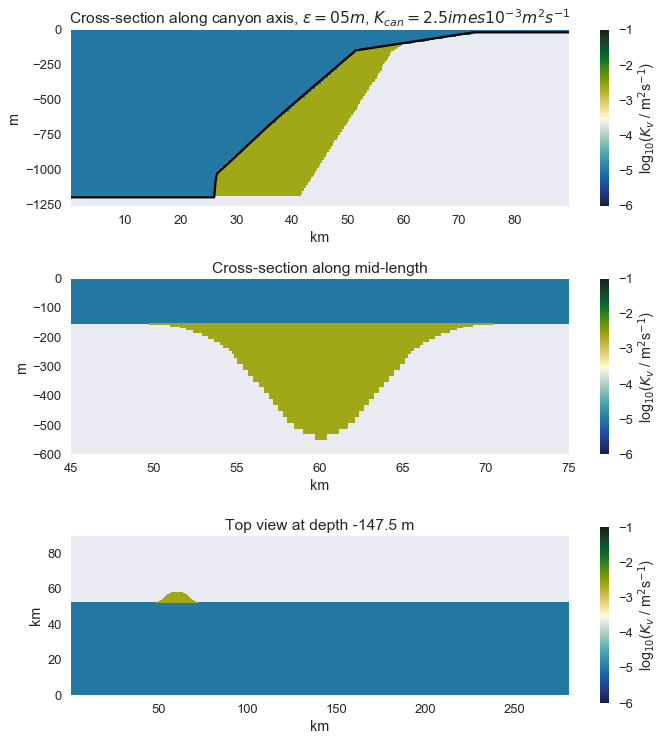

In [25]:
sns.set_style('dark')
fig, ax1, ax2, ax3 = plot_sections(kv_final_e05_kv2p5E3, '$\epsilon=05 m$, $K_{can}=2.5\times10^{-3} m^2s^{-1}$')

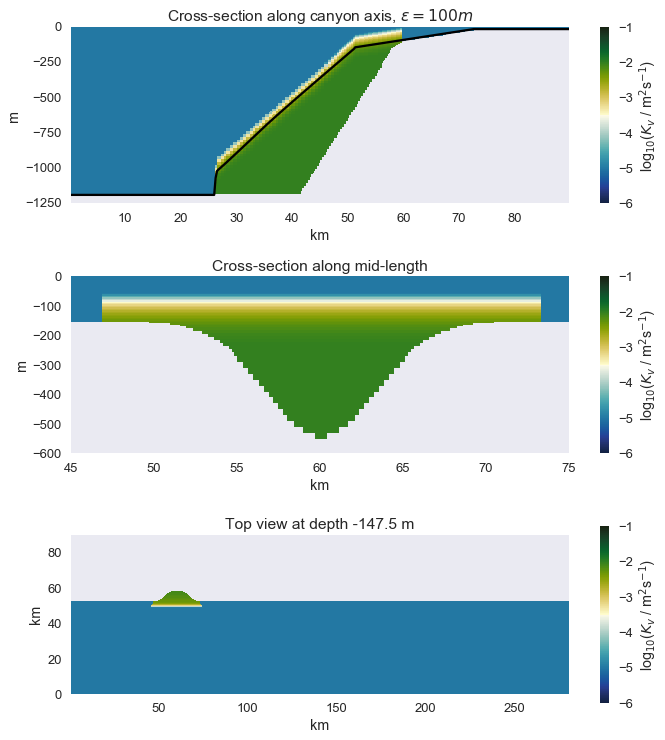

In [25]:
sns.set_style('dark')
fig, ax1, ax2, ax3 = plot_sections(kv_final_e100, '$\epsilon=100 m$')

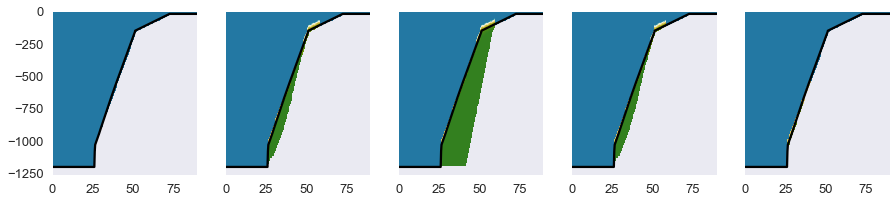

In [28]:
# Make sure it is all good (i.e. plot a lot of cross sections)

masked_array = np.ma.masked_array(np.log10(kv_final_e50), mask = land_mask)

fig, ax = plt.subplots(1,5, figsize=(15,3), sharey = True)
mesh = ax[0].pcolor(Y[:]/1000,RC[:], masked_array[:,:,20],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[1].pcolor(Y[:]/1000,RC[:], masked_array[:,:,120],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[2].pcolor(Y[:]/1000,RC[:], masked_array[:,:,180],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[3].pcolor(Y[:]/1000,RC[:], masked_array[:,:,240],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[4].pcolor(Y[:]/1000,RC[:], masked_array[:,:,285],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)

for ii in range(5):
    ax[ii].plot(Y[:]/1000, -depth_Can[:,280], 'k-')


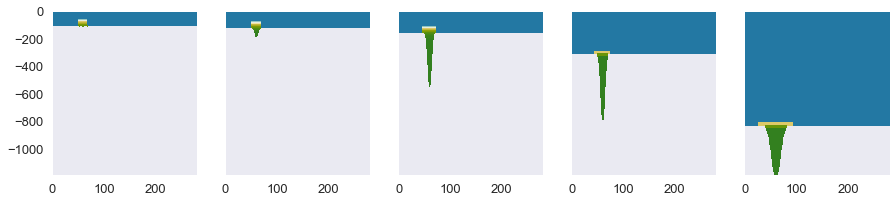

In [29]:
# Make sure it is all good (i.e. plot a lot of cross sections)
masked_array = np.ma.masked_array(np.log10(kv_final_e50), mask = land_mask)

fig, ax = plt.subplots(1,5, figsize=(15,3), sharey = True)
mesh = ax[0].pcolor(X[:]/1000,RC[:], masked_array[:,267,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[1].pcolor(X[:]/1000,RC[:], masked_array[:,257,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[2].pcolor(X[:]/1000,RC[:], masked_array[:,227,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[3].pcolor(X[:]/1000,RC[:], masked_array[:,200,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)
mesh = ax[4].pcolor(X[:]/1000,RC[:], masked_array[:,100,:],
                    vmax=-1, vmin=-6, cmap = cmo.cm.delta)


In [27]:
# filenames to save

dt = np.dtype('>f8')  # float 64 big endian

# Run 24, e=5, kv=1.2E-2
filename1 = "%dx%dx%d/KrDiff_e05_kv1p2E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(filename1,mode='wb')
kv_final_e05_1p2E2.astype(dt).tofile(fileobj,"")
fileobj.close()

# Runs 27, 07, 11, 08, 09, 12, 10, 13, e=5 to 150, kv=1E-2
filename2 = "%dx%dx%d/KrDiff_e05_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename3 = "%dx%dx%d/KrDiff_e10_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename4 = "%dx%dx%d/KrDiff_e15_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename5 = "%dx%dx%d/KrDiff_e25_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename6 = "%dx%dx%d/KrDiff_e50_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename7 = "%dx%dx%d/KrDiff_e75_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename8 = "%dx%dx%d/KrDiff_e100_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
#filename9 = "%dx%dx%d/KrDiff_e150_kv1E2_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

fileobj = open(filename2,mode='wb')
kv_final_e05.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename3,mode='wb')
kv_final_e10.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename4,mode='wb')
kv_final_e15.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename5,mode='wb')
kv_final_e25.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename6,mode='wb')
kv_final_e50.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename7,mode='wb')
kv_final_e75.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename8,mode='wb')
kv_final_e100.astype(dt).tofile(fileobj,"")
fileobj.close()

#fileobj = open(filename9,mode='wb')
#kv_final_e150.astype(dt).tofile(fileobj,"")
#fileobj.close()


In [28]:
dt = np.dtype('>f8')  # float 64 big endian

# Run 23, e=5, kv=8E-3
#filename10 = "%dx%dx%d/KrDiff_e05_kv8E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
#fileobj = open(filename10,mode='wb')
#kv_final_e05_kv8E3.astype(dt).tofile(fileobj,"")
#fileobj.close()

# Run 17, 21, 22 e=5,25,100, kv=5E-3
filename11 = "%dx%dx%d/KrDiff_e05_kv5E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename12 = "%dx%dx%d/KrDiff_e25_kv5E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename13 = "%dx%dx%d/KrDiff_e100_kv5E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

fileobj = open(filename11,mode='wb')
kv_final_e05_kv5E3.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename12,mode='wb')
kv_final_e25_kv5E3.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename13,mode='wb')
kv_final_e100_kv5E3.astype(dt).tofile(fileobj,"")
fileobj.close()

# Run 25, e=5, kv=2.5E-3
#filename14 = "%dx%dx%d/KrDiff_e05_kv2p5E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
#fileobj = open(filename14,mode='wb')
#kv_final_e05_kv2p5E3.astype(dt).tofile(fileobj,"")
#fileobj.close()

In [29]:
dt = np.dtype('>f8')  # float 64 big endian

# Run 16, 19, 20, e=5,25,100, kv=1E-3
filename15 = "%dx%dx%d/KrDiff_e05_kv1E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename16 = "%dx%dx%d/KrDiff_e25_kv1E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
filename17 = "%dx%dx%d/KrDiff_e100_kv1E3_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)

fileobj = open(filename15,mode='wb')
kv_final_e05_kv1E3.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename16,mode='wb')
kv_final_e25_kv1E3.astype(dt).tofile(fileobj,"")
fileobj.close()

fileobj = open(filename17,mode='wb')
kv_final_e100_kv1E3.astype(dt).tofile(fileobj,"")
fileobj.close()

# Run 26, e=5, kv=5E-4
#filename18 = "%dx%dx%d/KrDiff_e05_kv5E4_%dzlev_%dx%d_Quad.bin" %(nx,ny,nz,nz,nx,ny)
#fileobj = open(filename18,mode='wb')
#kv_final_e05_kv5E4.astype(dt).tofile(fileobj,"")
#fileobj.close()

#### Quick, dirty check to one of the files 

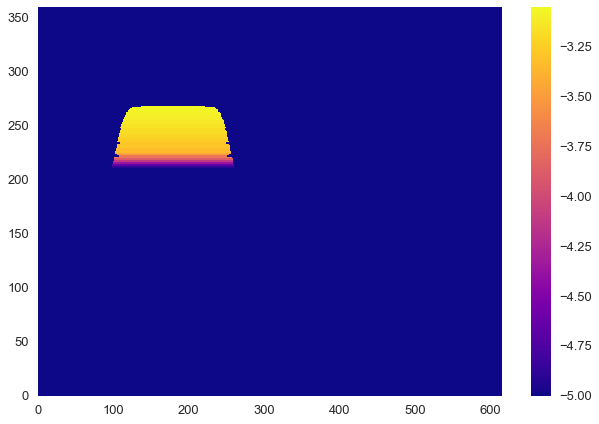

In [30]:
# Check that the values of the file are in the right order 

dt = np.dtype('>f8')  # float 64 big endian

fileNAME = filename17
kv=np.fromfile(fileNAME, dt)

Kv=np.reshape(kv,(nz,ny,nx),order='C')
np.shape(Kv)

plt.pcolor(np.log10(Kv[29,:,:]), cmap='plasma')
plt.colorbar()
